# Wildfire Risk Assessment

In [11]:
#dataset paths

from pathlib import Path
P_ERA5   = Path(r"D:\606Data\ERA5\a146370166d1a2f287c47c3cabcf4ec9\data_stream-moda_stepType-avgua.nc")
P_HLS    = Path(r"D:\606Data\HLS_Dataset\Data")
P_MODIS  = Path(r"D:\606Data\MODISTera_GEOTIFF_File")  
P_OPERA  = Path(r"D:\606Data\OPERA_Dataset\Data")
P_SMAP9  = Path(r"D:\606Data\SMAP_Enhanced_L3_Radiometer_Global_and_PolarGrid_Daily_9km_EASE_Grid_SoilMoisture_V006\Data")
P_SMAP36 = Path(r"D:\606Data\SMAP_L3_Radiometer_Global_Daily_36km_EAS_Grid_Soil_Moisture_V009\Data")
P_S1SP   = Path(r"D:\606Data\SMAPSentinel_1_L2_RadiometerRadar_30_Second_Scene_3_km_EASE_Grid_Soil_Moisture_V003\Data")
P_VIIRS_L3 = Path(r"D:\606Data\VIIRSNPP_Thermal_Anomalies_and_Fire_Daily_L3_Global_1km_SIN_rid_V002\Data")
P_VIIRS_G = Path(r"D:\606Data\VIIRS_L3_FireMask_Geo"); P_VIIRS_G.mkdir(parents=True, exist_ok=True)
OUT_CHIPS = Path(r"D:\606Data\chips_viirs1km_32x32"); OUT_CHIPS.mkdir(parents=True, exist_ok=True)


In [12]:
import pandas as pd
import glob

VIIRS_NPP_375M_DIR = r"D:\606Data\VIIRSNPP_Active_Fires_6Min_L2Swath_375m_V002\Data"
VIIRS_JPSS1_375M_DIR = r"D:\606Data\VIIRSJPSS1_Active_Fires_6Min_L2Swath_375m_V002\Data"

search_pattern = os.path.join(VIIRS_JPSS1_375M_DIR, '**', f"*.nc.detections.csv")
file_list = glob.glob(search_pattern, recursive=True)

if not file_list:
    search_pattern = os.path.join(VIIRS_NPP_375M_DIR, '**', f"*.nc.detections.csv")
    file_list = glob.glob(search_pattern, recursive=True)

if not file_list:
    print("CRITICAL ERROR: Could not find any '*.nc.detections.csv' files to inspect.")
else:
    sample_file = file_list[0]
    print(f"--- Inspecting sample file: {sample_file} ---")
    
    try:
        df = pd.read_csv(sample_file)
        
        print("\nColumns Found")
        display(list(df.columns))
        
        print("\nFirst 5 Rows of Data")
        display(df.head().to_string())
        
        if 'confidence' in df.columns:
            print("\nAnalysis of 'confidence' column")
            display(df['confidence'].value_counts())
        else:
            print("\nANALYSIS")
            display("CRITICAL: The 'confidence' column is MISSING.")
            
    except pd.errors.EmptyDataError:
        print("ANALYSIS")
        print("File is empty.")
    except Exception as e:
        print(f"--- ERROR ---")
        print(f"Could not read file. Error: {e}")

--- Inspecting sample file: D:\606Data\VIIRSJPSS1_Active_Fires_6Min_L2Swath_375m_V002\Data\VJ114IMG.A2024202.0830.002.2024202144242.nc.detections.csv ---

Columns Found


['latitude',
 'longitude',
 'confidence',
 'FRP',
 'Rad13',
 'T4',
 'T5',
 'WinSize',
 'SolZen',
 'SolAz',
 'ViewZen',
 'ViewAz',
 'DayOfYear']


First 5 Rows of Data


'    latitude   longitude  confidence       FRP     Rad13         T4         T5  WinSize      SolZen  SolAz    ViewZen     ViewAz  DayOfYear\n0  49.882560 -115.382250         8.0  1.685347  0.450740  302.49190  285.51047     10.0  108.970000  10.42  66.840000  89.140000        0.0\n1  49.882640 -115.374270         8.0  2.343223  0.416773  297.62494  285.19305     10.0  108.970000  10.42  66.830000  89.140000        0.0\n2  49.875830 -115.380620         8.0  1.685347  0.450740  295.68912  284.05652     10.0  108.970000  10.42  66.840000  89.110000        0.0\n3  49.869087 -115.380394         8.0  1.001427  0.400598  297.26877  286.04202     10.0  108.979996  10.42  66.840000  89.079994        0.0\n4  49.861890 -115.421684         8.0  5.493655  0.515440  328.92334  287.76923      0.0  108.990000  10.38  66.909996  89.020000        0.0'


Analysis of 'confidence' column


confidence
8.0    373
9.0      1
Name: count, dtype: int64

In [38]:
import os
import pandas as pd
import numpy as np
import rasterio
from rasterio.features import rasterize
from rasterio.warp import reproject, Resampling
import geopandas as gpd
from glob import glob
from tqdm import tqdm
import xarray as xr
import datetime
import torch.nn.utils
from scipy.ndimage import distance_transform_edt

OUTPUT_BASE = r"D:\606Data\Processed\Chips"
TARGET_DATES = ['2024204', '2024207', '2024205', '2024203', '2024202']

ERA5_FILE = r"D:\606Data\ERA5\a146370166d1a2f287c47c3cabcf4ec9\data_stream-moda_stepType-avgua.nc"

MODIS_STATIC_FILE = glob(os.path.join(r"D:\606Data\MODISTera_GEOTIFF_File", "**/*.tif"), recursive=True)[0] 

VIIRS_375M_DIRS = [
    r"D:\606Data\VIIRSJPSS1_Active_Fires_6Min_L2Swath_375m_V002\Data",
    r"D:\606Data\VIIRSNPP_ActiveFires_6Min_L2Swath_375m_V002\Data"
]

# PARAMETERS
CHIP_SIZE = 224
BUFFER_METERS = 187.5
CONFIDENCE_THRESHOLD = 7


def calculate_distance_map(height, width):
    """Creates a normalized map showing distance to the nearest edge."""

    edge_map = np.ones((height, width), dtype=np.uint8)
    edge_map[1:-1, 1:-1] = 0
    
    dist_map = distance_transform_edt(1 - edge_map)
    
    max_dist = dist_map.max()
    dist_map_norm = dist_map / max_dist if max_dist > 0 else dist_map
    
    return dist_map_norm

def load_and_resample_feature(src_path, modis_profile, variable_key):
    """Loads a feature (NC, H5, or TIF) and resamples it to the MODIS chip grid."""
    
    src_data, src_crs, src_transform = None, None, None

    is_hdf_nc = variable_key is not None 

    if is_hdf_nc:
        try:
            with xr.open_dataset(src_path, engine='netcdf4', decode_times=False) as ds:
                data_var = ds[variable_key].squeeze().isel(valid_time=0) 
                
                src_crs = rasterio.crs.CRS.from_epsg(4326)
                src_transform = rasterio.transform.from_bounds(
                    data_var['longitude'].values.min(), data_var['latitude'].values.min(),
                    data_var['longitude'].values.max(), data_var['latitude'].values.max(),
                    data_var.shape[1], data_var.shape[0]
                )
                src_data = data_var.values
                if src_data.ndim > 2: src_data = src_data[0]
            
        except Exception as e:
            print(f"DEBUG FAIL HDF/NC load for {os.path.basename(src_path)}: {e}")
            return None
            
    else:
        try:
            with rasterio.open(src_path) as src:
                src_data = src.read(1) 
                src_crs = src.crs
                src_transform = src.transform
        except Exception as e:
            print(f"DEBUG FAIL TIF load for {os.path.basename(src_path)}: {e}")
            return None

    target_array = np.empty((modis_profile['height'], modis_profile['width']), dtype=np.float32)
    
    reproject(
        source=src_data,
        destination=target_array,
        src_transform=src_transform,
        src_crs=src_crs,
        dst_transform=modis_profile['transform'],
        dst_crs=modis_profile['crs'],
        resampling=Resampling.average
    )
    
    target_array = np.maximum(target_array, 0)
    return target_array / 5000.0

#Batch Processing
def process_batch():
    
    print("--- 1. Data Setup and Cleanup ---")
    current_pos_path = os.path.join(OUTPUT_BASE, "Positive")
    if os.path.exists(current_pos_path):
        timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        os.rename(current_pos_path, os.path.join(OUTPUT_BASE, f"Positive_FAILED__{timestamp}"))
        print(f"Old 1-Channel data backed up to: Positive_FAILED__{timestamp}")

    os.makedirs(os.path.join(OUTPUT_BASE, "Positive", "Images"), exist_ok=True)
    os.makedirs(os.path.join(OUTPUT_BASE, "Positive", "Labels"), exist_ok=True)
    os.makedirs(os.path.join(OUTPUT_BASE, "Negative", "Images"), exist_ok=True)
    os.makedirs(os.path.join(OUTPUT_BASE, "Negative", "Labels"), exist_ok=True)

    try:
        with rasterio.open(MODIS_STATIC_FILE) as src:
            modis_profile = src.profile
            h, w = src.shape
    except Exception as e:
        print(f"CRITICAL ERROR: Failed to load MODIS static file profile: {e}")
        return 
        
    print(f"Loaded MODIS grid: {h}x{w}. Loading features...")

    # Load C1 (Risk)
    era5_data = load_and_resample_feature(ERA5_FILE, modis_profile, variable_key='t')
    # Load C2 (Vegetation)
    modis_veg_data = load_and_resample_feature(MODIS_STATIC_FILE, modis_profile, variable_key=None)

    if era5_data is None or modis_veg_data is None:
        print("CRITICAL ERROR: Failed to load static feature data. Check DEBUG FAIL messages.")
        return
    
    # C3: Spatial Context
    distance_map = calculate_distance_map(h, w)

    print("--- 2. Starting Multi-Source Stacking ---")
    grand_total = 0
    
    for date in tqdm(TARGET_DATES):
        stacked_features = np.stack([era5_data, modis_veg_data, distance_map], axis=-1)
        
        fire_points = []
        for v_dir in VIIRS_375M_DIRS:
            fire_files = glob(os.path.join(v_dir, f"**/*A{date}*.csv"), recursive=True)
            fire_files += glob(os.path.join(v_dir, f"**/*A{date}*.txt"), recursive=True)
            
            for path in fire_files:
                try:
                    df = pd.read_csv(path)
                    df['confidence'] = pd.to_numeric(df['confidence'], errors='coerce')
                    df = df[df['confidence'] >= CONFIDENCE_THRESHOLD]
                    if not df.empty:
                        gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude), crs="EPSG:4326")
                        fire_points.append(gdf)
                except: continue
        
        if not fire_points:
            print(f"Skipping {date}: No valid fire points for labeling.")
            continue
            
        all_fires = pd.concat(fire_points, ignore_index=True)
        
        # 5. Rasterize Labels
        fires_proj = all_fires.to_crs(modis_profile['crs'])
        fires_proj['geometry'] = fires_proj.geometry.buffer(BUFFER_METERS)
        
        mask = np.zeros((h, w), dtype=np.uint8)
        rasterize(
            ((geom, 1) for geom in fires_proj.geometry), 
            out=mask, 
            transform=modis_profile['transform'], 
            default_value=1,
            dtype=rasterio.uint8
        )
        
        date_positives = 0
        for r in range(0, h - CHIP_SIZE + 1, CHIP_SIZE):
            for c in range(0, w - CHIP_SIZE + 1, CHIP_SIZE):
                chip_mask = mask[r:r+CHIP_SIZE, c:c+CHIP_SIZE]
                
                if np.any(chip_mask == 1):
                    chip_img = stacked_features[r:r+CHIP_SIZE, c:c+CHIP_SIZE, :]
                    fname = f"{date}_{r}_{c}_3CH.npy" 
                    
                    np.save(os.path.join(OUTPUT_BASE, "Positive", "Images", fname), chip_img)
                    np.save(os.path.join(OUTPUT_BASE, "Positive", "Labels", fname), chip_mask)
                    date_positives += 1
                
        grand_total += date_positives
        print(f"Generated {date_positives} 3-Channel chips.")


    print(f"\n=========================================")
    print(f"BATCH COMPLETE: Multi-Source Stacker")
    print(f"Total RAW 3-CH Positive Chips Created: {grand_total}")
    print(f"=========================================")

if __name__ == "__main__":
    process_batch()

--- 1. Data Setup and Cleanup ---
Old 1-Channel data backed up to: Positive_FAILED__20251118_133329
Loaded MODIS grid: 2400x2400. Loading features...
--- 2. Starting Multi-Source Stacking ---


 20%|████████████████▊                                                                   | 1/5 [00:01<00:04,  1.19s/it]

Generated 0 3-Channel chips.


 40%|█████████████████████████████████▌                                                  | 2/5 [00:02<00:03,  1.01s/it]

Generated 0 3-Channel chips.


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:03<00:02,  1.02s/it]

Generated 0 3-Channel chips.


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:03<00:00,  1.10it/s]

Generated 0 3-Channel chips.


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.01it/s]

Generated 0 3-Channel chips.

BATCH COMPLETE: Multi-Source Stacker
Total RAW 3-CH Positive Chips Created: 0


In [43]:
import os
import pandas as pd
from glob import glob

DEBUG_DATE = '2024202' 
CONFIDENCE_THRESHOLD = 7
VIIRS_375M_DIRS = [
    r"D:\606Data\VIIRSJPSS1_Active_Fires_6Min_L2Swath_375m_V002\Data",
    r"D:\606Data\VIIRSNPP_ActiveFires_6Min_L2Swath_375m_V002\Data"
]

def debug_label_filter():
    print(f"--- DEBUGGING LABEL FILTER FOR DATE {DEBUG_DATE} ---")
    total_points_before = 0
    total_points_after = 0
    
    for v_dir in VIIRS_375M_DIRS:
        fire_files = glob(os.path.join(v_dir, f"**/*A{DEBUG_DATE}*.csv"), recursive=True)
        fire_files += glob(os.path.join(v_dir, f"**/*A{DEBUG_DATE}*.txt"), recursive=True)
        
        for path in fire_files:
            filename = os.path.basename(path)
            
            try:
                df = pd.read_csv(path)
                
                if 'confidence' not in df.columns:
                    print(f"❌ FILE: {filename} - Confidence column NOT FOUND. Skipping.")
                    print(f"  Available columns: {list(df.columns)}")
                    continue
                    
                points_before = len(df)
                total_points_before += points_before
                
                df['confidence'] = pd.to_numeric(df['confidence'], errors='coerce')
                df_filtered = df[df['confidence'] >= CONFIDENCE_THRESHOLD].dropna(subset=['confidence'])
                
                points_after = len(df_filtered)
                total_points_after += points_after
                
                print(f"✅ FILE: {filename}")
                print(f"  Points Before Filter: {points_before}")
                print(f"  Points After Filter:  {points_after}")
                
            except Exception as e:
                print(f"❌ FILE: {filename} - READ ERROR: {e}")

    print("\n--- FINAL SUMMARY ---")
    print(f"Total Points Before Filter: {total_points_before}")
    print(f"Total Points After Filter:  {total_points_after}")

if __name__ == "__main__":
    debug_label_filter()

--- DEBUGGING LABEL FILTER FOR DATE 2024202 ---
✅ FILE: VJ114IMG.A2024202.0830.002.2024202144242.nc.detections.csv
  Points Before Filter: 374
  Points After Filter:  374
✅ FILE: VJ114IMG.A2024202.1012.002.2024202171210.nc.detections.csv
  Points Before Filter: 1512
  Points After Filter:  1512
✅ FILE: VJ114IMG.A2024202.1948.002.2024203030315.nc.detections.csv
  Points Before Filter: 172
  Points After Filter:  172
✅ FILE: VJ114IMG.A2024202.1954.002.2024203033539.nc.detections.csv
  Points Before Filter: 2105
  Points After Filter:  2105
✅ FILE: VJ114IMG.A2024202.2130.002.2024203033540.nc.detections.csv
  Points Before Filter: 132
  Points After Filter:  132
✅ FILE: VJ114IMG.A2024202.2136.002.2024203033537.nc.detections.csv
  Points Before Filter: 1853
  Points After Filter:  1853
✅ FILE: VNP14IMG.A2024202.0948.002.2024213180147.nc.detections.csv
  Points Before Filter: 1662
  Points After Filter:  1662
✅ FILE: VNP14IMG.A2024202.1124.002.2024213180133.nc.detections.csv
  Points Before 

In [44]:
import pandas as pd
import os
from glob import glob

DEBUG_DATE = '2024202' 
VIIRS_375M_DIRS = [
    r"D:\606Data\VIIRSJPSS1_Active_Fires_6Min_L2Swath_375m_V002\Data",
    r"D:\606Data\VIIRSNPP_ActiveFires_6Min_L2Swath_375m_V002\Data"
]

def inspect_columns():
    print("--- INSPECTING GEOSPATIAL COLUMNS ---")
    
    search_path = os.path.join(VIIRS_375M_DIRS[0], f"**/*A{DEBUG_DATE}*.csv")
    first_file = glob(search_path, recursive=True)
    
    if not first_file:
        print("CRITICAL ERROR: No CSV file found in the expected path for inspection.")
        return

    sample_path = first_file[0]
    df = pd.read_csv(sample_path)
    
    print(f"Sample File: {os.path.basename(sample_path)}")
    print("\nAvailable Columns (Looking for 'longitude' and 'latitude'):")
    
    for col in df.columns:
        print(f"- {col}")

if __name__ == "__main__":
    inspect_columns()

--- INSPECTING GEOSPATIAL COLUMNS ---
Sample File: VJ114IMG.A2024202.0830.002.2024202144242.nc.detections.csv

Available Columns (Looking for 'longitude' and 'latitude'):
- latitude
- longitude
- confidence
- FRP
- Rad13
- T4
- T5
- WinSize
- SolZen
- SolAz
- ViewZen
- ViewAz
- DayOfYear


In [14]:
import os
import pandas as pd
import geopandas as gpd
from glob import glob

TARGET_DATES = ['2024204', '2024207', '2024205', '2024203', '2024202']
TARGET_CRS = "EPSG:6842" 
CONFIDENCE_THRESHOLD = 7
VIIRS_375M_DIRS = [
    r"D:\606Data\VIIRSJPSS1_Active_Fires_6Min_L2Swath_375m_V002\Data",
    r"D:\606Data\VIIRSNPP_ActiveFires_6Min_L2Swath_375m_V002\Data"
]

def check_projected_bounds():
    print("CHECKING UTM PROJECTION INTEGRITY")
    
    for date in TARGET_DATES:
        fire_points = []
        
        for v_dir in VIIRS_375M_DIRS:
            fire_files = glob(os.path.join(v_dir, f"**/*A{date}*.csv"), recursive=True)
            fire_files += glob(os.path.join(v_dir, f"**/*A{date}*.txt"), recursive=True)
            
            for path in fire_files:
                try:
                    df = pd.read_csv(path)
                    df['latitude'] = pd.to_numeric(df['latitude'], errors='coerce')
                    df['longitude'] = pd.to_numeric(df['longitude'], errors='coerce')
                    df.dropna(subset=['latitude', 'longitude'], inplace=True)
                    df['confidence'] = pd.to_numeric(df['confidence'], errors='coerce')
                    df = df[df['confidence'] >= CONFIDENCE_THRESHOLD].dropna(subset=['confidence'])
                    
                    if not df.empty:
                        gdf = gpd.GeoDataFrame(
                            df, 
                            geometry=gpd.points_from_xy(df.longitude, df.latitude), 
                            crs="EPSG:4326"
                        )
                        fire_points.append(gdf)
                except: continue
        
        if not fire_points:
            print(f"[{date}] - No points found after cleanup.")
            continue
            
        all_fires = pd.concat(fire_points, ignore_index=True)
        
        fires_proj = all_fires.to_crs(TARGET_CRS)
        
        minx, miny, maxx, maxy = fires_proj.total_bounds
        
        print(f"[{date}] - Points: {len(all_fires)}")
        print(f"  X-Range (Min/Max): {minx:.2f} / {maxx:.2f}")
        print(f"  Y-Range (Min/Max): {miny:.2f} / {maxy:.2f}")
        
        if minx < 0 or miny < 0:
             print(" WARNING: Coordinates contain negative values (Suggests data near the equator or an incorrect CRS).")
        if minx > 1000000 or miny > 1000000:
             print(" WARNING: Coordinates are extremely large (Suggests projection failure or very large extent).")
            
if __name__ == "__main__":
    check_projected_bounds()

CHECKING UTM PROJECTION INTEGRITY
[2024204] - Points: 9305
  X-Range (Min/Max): -105144.61 / 2417600.75
  Y-Range (Min/Max): -1700755.94 / 2255081.87
[2024207] - Points: 6950
  X-Range (Min/Max): -6683.39 / 3978019.66
  Y-Range (Min/Max): -2630697.72 / 2104252.53
[2024205] - Points: 6846
  X-Range (Min/Max): -10707.46 / 2884949.93
  Y-Range (Min/Max): -1604494.97 / 1900520.23
[2024203] - Points: 6303
  X-Range (Min/Max): -702600.13 / 3905626.30
  Y-Range (Min/Max): -2466446.09 / 2489766.95
[2024202] - Points: 8990
  X-Range (Min/Max): -702862.70 / 3789949.80
  Y-Range (Min/Max): -2590805.50 / 2430845.31


In [16]:
import os
import pandas as pd
import numpy as np
import rasterio
from rasterio.features import rasterize
import geopandas as gpd
from glob import glob
from tqdm import tqdm
import datetime
from rasterio.transform import from_bounds

OUTPUT_BASE = r"D:\606Data\Processed\Chips"
TARGET_DATES = ['2024204', '2024207', '2024205', '2024203', '2024202']

# Projection: Sinusoidal (EPSG:6842) 
TARGET_CRS = "EPSG:6842" 
TARGET_RESOLUTION = 30.0 
CHIP_SIZE = 224 
BUFFER_METERS = 375.0 

# Features to rasterize
FEATURE_COLUMNS = ['T4', 'FRP', 'T5'] 

VIIRS_375M_DIRS = [
    r"D:\606Data\VIIRSJPSS1_Active_Fires_6Min_L2Swath_375m_V002\Data",
    r"D:\606Data\VIIRSNPP_ActiveFires_6Min_L2Swath_375m_V002\Data"
]

def process_direct_extraction():
    
    current_pos_path = os.path.join(OUTPUT_BASE, "Positive")
    if os.path.exists(current_pos_path):
        timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        os.rename(current_pos_path, os.path.join(OUTPUT_BASE, f"Positive_PREV_{timestamp}"))
        
    os.makedirs(os.path.join(OUTPUT_BASE, "Positive", "Images"), exist_ok=True)
    os.makedirs(os.path.join(OUTPUT_BASE, "Positive", "Labels"), exist_ok=True)
    grand_total = 0
    
    chip_span_m = CHIP_SIZE * TARGET_RESOLUTION
    half_span = chip_span_m / 2.0

    print("Starting Direct Chip Extraction")
    
    for date in tqdm(TARGET_DATES):
        # A. Loading Data
        fire_dfs = []
        for v_dir in VIIRS_375M_DIRS:
            fire_files = glob(os.path.join(v_dir, f"**/*A{date}*.csv"), recursive=True)
            fire_files += glob(os.path.join(v_dir, f"**/*A{date}*.txt"), recursive=True)
            
            for path in fire_files:
                try:
                    df = pd.read_csv(path)
                    cols_to_check = ['latitude', 'longitude'] + FEATURE_COLUMNS + ['confidence']
                    for col in cols_to_check:
                        df[col] = pd.to_numeric(df[col], errors='coerce')
                    
                    df.dropna(subset=cols_to_check, inplace=True)
                    df = df[df['confidence'] >= 7] 
                    
                    if not df.empty:
                        fire_dfs.append(df)
                except: continue
        
        if not fire_dfs:
            print(f"Skipping {date}: No valid points.")
            continue
            
        full_df = pd.concat(fire_dfs, ignore_index=True)
        
        gdf = gpd.GeoDataFrame(
            full_df,
            geometry=gpd.points_from_xy(full_df.longitude, full_df.latitude),
            crs="EPSG:4326"
        ).to_crs(TARGET_CRS)
        
        date_chips = 0
        
        MAX_CHIPS_PER_DAY = 500 
        gdf = gdf.sample(frac=1).reset_index(drop=True)
        
        for idx, row in gdf.iterrows():
            if date_chips >= MAX_CHIPS_PER_DAY:
                break
            
            pt = row.geometry
            minx = pt.x - half_span
            maxx = pt.x + half_span
            miny = pt.y - half_span
            maxy = pt.y + half_span
            
            transform = from_bounds(minx, miny, maxx, maxy, CHIP_SIZE, CHIP_SIZE)
            
            neighbors = gdf.cx[minx:maxx, miny:maxy]
            
            if neighbors.empty: continue 

            stacked_features = np.zeros((CHIP_SIZE, CHIP_SIZE, 3), dtype=np.float32)
            
            for i, col in enumerate(FEATURE_COLUMNS):
                shapes = ((geom.buffer(BUFFER_METERS), val) for geom, val in zip(neighbors.geometry, neighbors[col]))
                
                channel = rasterize(
                    shapes,
                    out_shape=(CHIP_SIZE, CHIP_SIZE),
                    transform=transform,
                    fill=0,
                    dtype=np.float32
                )
                
                mval = channel.max()
                if mval > 0: channel /= mval
                
                stacked_features[:, :, i] = channel
                
            shapes_lbl = ((geom.buffer(BUFFER_METERS), 1) for geom in neighbors.geometry)
            mask = rasterize(
                shapes_lbl,
                out_shape=(CHIP_SIZE, CHIP_SIZE),
                transform=transform,
                fill=0,
                dtype=np.uint8
            )
            
            fname = f"{date}_point_{idx}_3CH.npy"
            np.save(os.path.join(OUTPUT_BASE, "Positive", "Images", fname), stacked_features)
            np.save(os.path.join(OUTPUT_BASE, "Positive", "Labels", fname), mask)
            date_chips += 1
            
        grand_total += date_chips
        print(f"  > {date}: Created {date_chips} chips.")

    print(f"FINAL SUCCESS: {grand_total} 3-Channel Chips Created")

if __name__ == "__main__":
    process_direct_extraction()

Starting Direct Chip Extraction


 20%|████████████████▊                                                                   | 1/5 [00:27<01:48, 27.23s/it]

  > 2024204: Created 500 chips.


 40%|█████████████████████████████████▌                                                  | 2/5 [00:57<01:26, 28.91s/it]

  > 2024207: Created 500 chips.


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:18<00:51, 25.52s/it]

  > 2024205: Created 500 chips.


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:35<00:22, 22.09s/it]

  > 2024203: Created 500 chips.


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:02<00:00, 24.52s/it]

  > 2024202: Created 500 chips.
FINAL SUCCESS: 2500 3-Channel Chips Created


In [53]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
import time
from glob import glob
from sklearn.model_selection import train_test_split
from tqdm import tqdm

DATA_DIR = r"D:\606Data\Processed\Chips\Positive"
IMG_DIR = os.path.join(DATA_DIR, "Images")
LBL_DIR = os.path.join(DATA_DIR, "Labels")

# Hyperparameters
NUM_EPOCHS = 15
LEARNING_RATE = 1e-4
BATCH_SIZE = 16
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# 1. DATASET LOADER (3-Channel)
class WildfireDataset(Dataset):
    def __init__(self, file_list):
        self.files = file_list
        
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        img_path = self.files[idx]
        fname = os.path.basename(img_path)
        lbl_path = os.path.join(LBL_DIR, fname)
        
        image = np.load(img_path).astype(np.float32)
        mask = np.load(lbl_path).astype(np.float32)
        
        image = np.transpose(image, (2, 0, 1))
        
        if len(mask.shape) == 2:
            mask = np.expand_dims(mask, axis=0)
            
        return torch.from_numpy(image), torch.from_numpy(mask)

# 2. U-NET MODEL (3-Channel Input)
class SimpleUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1): 
        super(SimpleUNet, self).__init__()
        
        def double_conv(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
                nn.ReLU(inplace=True)
            )
            
        self.d1 = double_conv(in_channels, 64)
        self.pool = nn.MaxPool2d(2)
        self.d2 = double_conv(64, 128)
        self.d3 = double_conv(128, 256)
        self.d4 = double_conv(256, 512)
        self.bottleneck = double_conv(512, 1024)
        
        self.up1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.u1 = double_conv(1024, 512)
        self.up2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.u2 = double_conv(512, 256)
        self.up3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.u3 = double_conv(256, 128)
        self.up4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.u4 = double_conv(128, 64)
        
        self.final = nn.Conv2d(64, out_channels, kernel_size=1)
        
    def forward(self, x):
        p1 = self.d1(x)
        x = self.pool(p1)
        p2 = self.d2(x)
        x = self.pool(p2)
        p3 = self.d3(x)
        x = self.pool(p3)
        p4 = self.d4(x)
        x = self.pool(p4)
        
        x = self.bottleneck(x)
        
        x = self.up1(x)
        x = torch.cat((p4, x), dim=1)
        x = self.u1(x)
        x = self.up2(x)
        x = torch.cat((p3, x), dim=1)
        x = self.u2(x)
        x = self.up3(x)
        x = torch.cat((p2, x), dim=1)
        x = self.u3(x)
        x = self.up4(x)
        x = torch.cat((p1, x), dim=1)
        x = self.u4(x)
        
        return self.final(x)

# 3. TRAINING UTILS
LOSS_FN = nn.BCEWithLogitsLoss()

def iou_metric(pred, target):
    pred = torch.sigmoid(pred)
    pred = (pred > 0.5).float()
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    return (intersection + 1e-6) / (union + 1e-6)

def train_fn(loader, model, optimizer, scaler):
    model.train()
    loop = tqdm(loader, desc='Training')
    total_loss = 0
    total_iou = 0

    for data, targets in loop:
        data = data.to(device=DEVICE)
        targets = targets.to(device=DEVICE)

        # Forward
        with torch.cuda.amp.autocast():
            predictions = model(data)
            loss = LOSS_FN(predictions, targets)
        
        # Backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
        total_iou += iou_metric(predictions, targets).item()
        loop.set_postfix(loss=loss.item(), iou=total_iou/(len(loop)+1)) 
        
    return total_loss / len(loader), total_iou / len(loader)

def check_val(loader, model):
    model.eval()
    total_iou = 0
    total_loss = 0
    with torch.no_grad():
        for data, targets in loader:
            data = data.to(DEVICE)
            targets = targets.to(DEVICE)
            preds = model(data)
            loss = LOSS_FN(preds, targets)
            total_loss += loss.item()
            total_iou += iou_metric(preds, targets).item()
    model.train()
    return total_loss / len(loader), total_iou / len(loader)

# 4. MAIN EXECUTION
def main():
    # A. Prepare Data
    all_files = glob(os.path.join(IMG_DIR, "*.npy"))
    if len(all_files) == 0:
        print("CRITICAL ERROR: No .npy files found. Check directory.")
        return
        
    train_files, val_files = train_test_split(all_files, test_size=0.2, random_state=42)
    print(f"Dataset: {len(train_files)} Train | {len(val_files)} Validation")
    
    train_loader = DataLoader(WildfireDataset(train_files), batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(WildfireDataset(val_files), batch_size=BATCH_SIZE, shuffle=False)
    
    # B. Setup Model
    model = SimpleUNet(in_channels=3, out_channels=1).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scaler = torch.cuda.amp.GradScaler()
    
    # C. Training Loop
    print("Starting Training...")
    for epoch in range(NUM_EPOCHS):
        train_loss, train_iou = train_fn(train_loader, model, optimizer, scaler)
        val_loss, val_iou = check_val(val_loader, model)
        
        print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
        print(f"  Train Loss: {train_loss:.4f} | Train IoU: {train_iou:.4f}")
        print(f"  Val Loss:   {val_loss:.4f} | Val IoU:   {val_iou:.4f}")
        
    # D. Save
    os.makedirs(r"D:\606Data\Processed\Models", exist_ok=True)
    torch.save(model.state_dict(), r"D:\606Data\Processed\Models\unet_3ch_final.pth")
    print("Model Saved!")

if __name__ == "__main__":
    main()

Using device: cuda
Dataset: 2000 Train | 500 Validation


C:\Users\sanjay\AppData\Local\Temp\ipykernel_18200\3285047579.py:178: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Starting Training...


Training:   0%|                                                                                | 0/125 [00:00<?, ?it/s]C:\Users\sanjay\AppData\Local\Temp\ipykernel_18200\3285047579.py:130: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training: 100%|██████████████████████████████████████████████| 125/125 [01:07<00:00,  1.86it/s, iou=0.884, loss=0.0116]


Epoch 1/15
  Train Loss: 0.2222 | Train IoU: 0.8908
  Val Loss:   0.0110 | Val IoU:   0.9851


Training: 100%|██████████████████████████████████████████████| 125/125 [00:34<00:00,  3.60it/s, iou=0.984, loss=0.0045]


Epoch 2/15
  Train Loss: 0.0071 | Train IoU: 0.9916
  Val Loss:   0.0046 | Val IoU:   0.9955


Training: 100%|█████████████████████████████████████████████| 125/125 [00:34<00:00,  3.67it/s, iou=0.989, loss=0.00242]


Epoch 3/15
  Train Loss: 0.0032 | Train IoU: 0.9969
  Val Loss:   0.0022 | Val IoU:   0.9981


Training: 100%|█████████████████████████████████████████████| 125/125 [00:34<00:00,  3.59it/s, iou=0.991, loss=0.00119]


Epoch 4/15
  Train Loss: 0.0017 | Train IoU: 0.9985
  Val Loss:   0.0012 | Val IoU:   0.9989


Training: 100%|████████████████████████████████████████████| 125/125 [00:35<00:00,  3.56it/s, iou=0.991, loss=0.000616]


Epoch 5/15
  Train Loss: 0.0010 | Train IoU: 0.9991
  Val Loss:   0.0007 | Val IoU:   0.9993


Training: 100%|████████████████████████████████████████████| 125/125 [00:35<00:00,  3.51it/s, iou=0.991, loss=0.000495]


Epoch 6/15
  Train Loss: 0.0006 | Train IoU: 0.9994
  Val Loss:   0.0005 | Val IoU:   0.9996


Training: 100%|████████████████████████████████████████████| 125/125 [00:36<00:00,  3.39it/s, iou=0.992, loss=0.000416]


Epoch 7/15
  Train Loss: 0.0004 | Train IoU: 0.9996
  Val Loss:   0.0003 | Val IoU:   0.9997


Training: 100%|████████████████████████████████████████████| 125/125 [00:37<00:00,  3.32it/s, iou=0.992, loss=0.000151]


Epoch 8/15
  Train Loss: 0.0003 | Train IoU: 0.9998
  Val Loss:   0.0002 | Val IoU:   0.9998


Training: 100%|████████████████████████████████████████████| 125/125 [00:38<00:00,  3.27it/s, iou=0.992, loss=0.000121]


Epoch 9/15
  Train Loss: 0.0002 | Train IoU: 0.9998
  Val Loss:   0.0002 | Val IoU:   0.9999


Training: 100%|████████████████████████████████████████████| 125/125 [00:37<00:00,  3.30it/s, iou=0.992, loss=0.000108]


Epoch 10/15
  Train Loss: 0.0001 | Train IoU: 0.9999
  Val Loss:   0.0001 | Val IoU:   0.9999


Training: 100%|████████████████████████████████████████████| 125/125 [00:37<00:00,  3.31it/s, iou=0.992, loss=0.000109]


Epoch 11/15
  Train Loss: 0.0001 | Train IoU: 0.9999
  Val Loss:   0.0001 | Val IoU:   0.9999


Training: 100%|██████████████████████████████████████████████| 125/125 [00:38<00:00,  3.28it/s, iou=0.992, loss=8.1e-5]


Epoch 12/15
  Train Loss: 0.0001 | Train IoU: 0.9999
  Val Loss:   0.0001 | Val IoU:   1.0000


Training: 100%|█████████████████████████████████████████████| 125/125 [00:38<00:00,  3.27it/s, iou=0.992, loss=4.54e-5]


Epoch 13/15
  Train Loss: 0.0001 | Train IoU: 1.0000
  Val Loss:   0.0000 | Val IoU:   1.0000


Training: 100%|██████████████████████████████████████████████| 125/125 [00:38<00:00,  3.26it/s, iou=0.992, loss=3.1e-5]


Epoch 14/15
  Train Loss: 0.0000 | Train IoU: 1.0000
  Val Loss:   0.0000 | Val IoU:   1.0000


Training: 100%|█████████████████████████████████████████████| 125/125 [00:38<00:00,  3.22it/s, iou=0.992, loss=2.97e-5]


Epoch 15/15
  Train Loss: 0.0000 | Train IoU: 1.0000
  Val Loss:   0.0000 | Val IoU:   1.0000
Model Saved!


Loading Model...


C:\Users\sanjay\AppData\Local\Temp\ipykernel_18200\2592496222.py:71: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH))


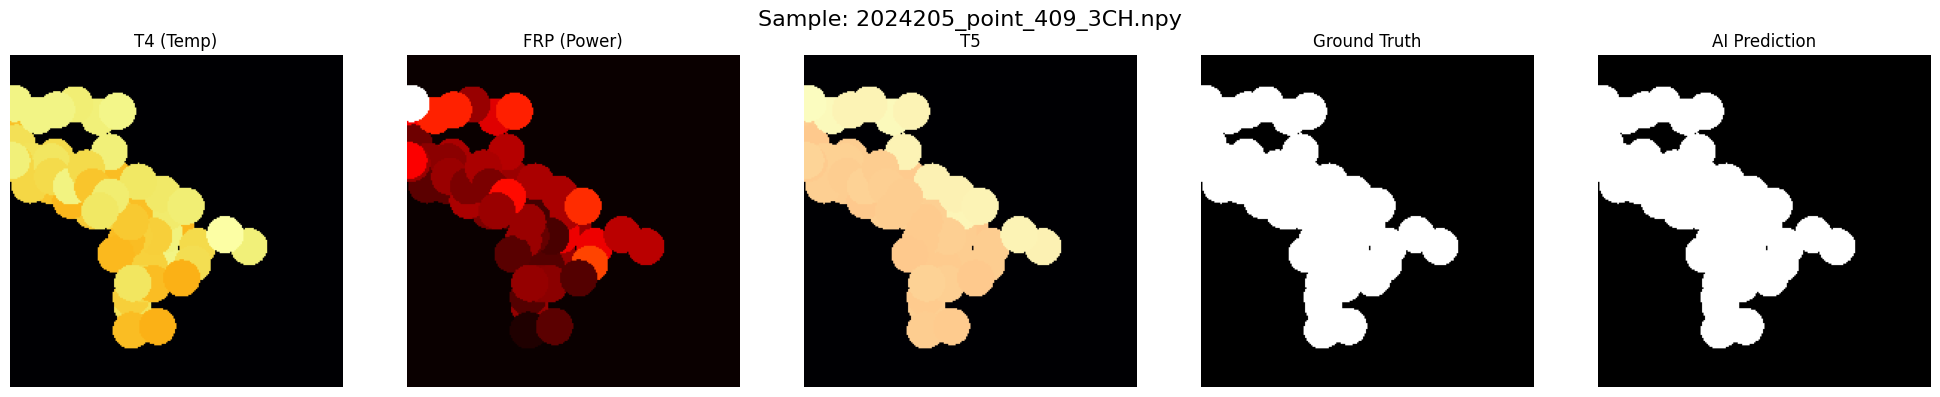

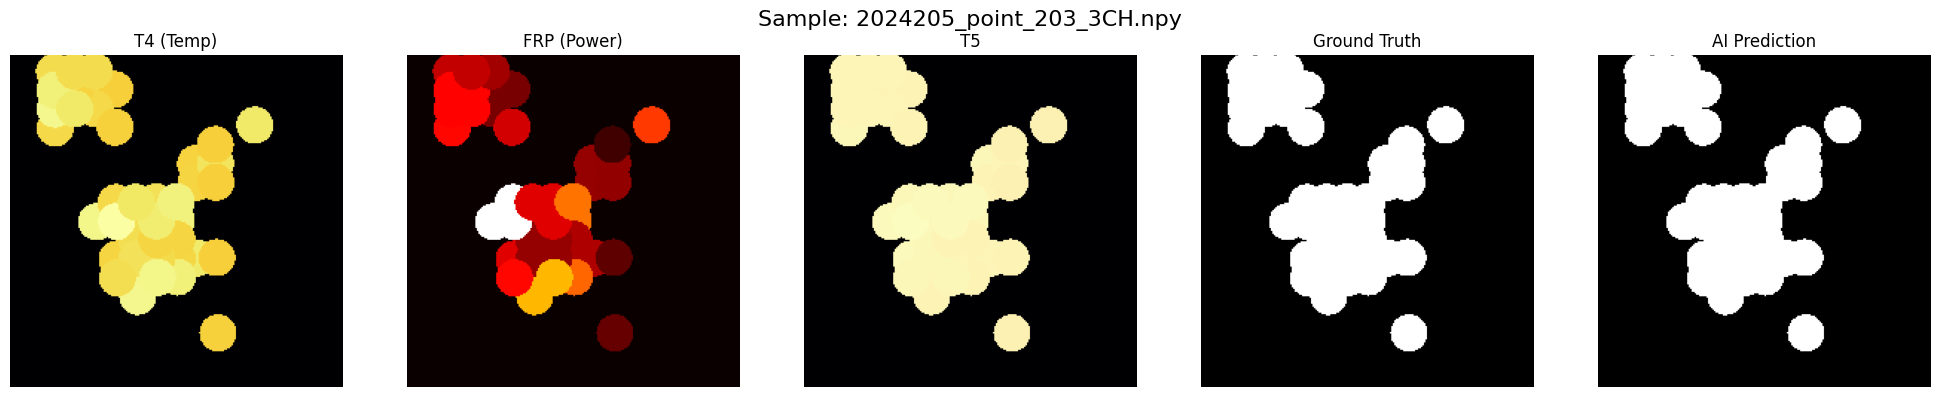

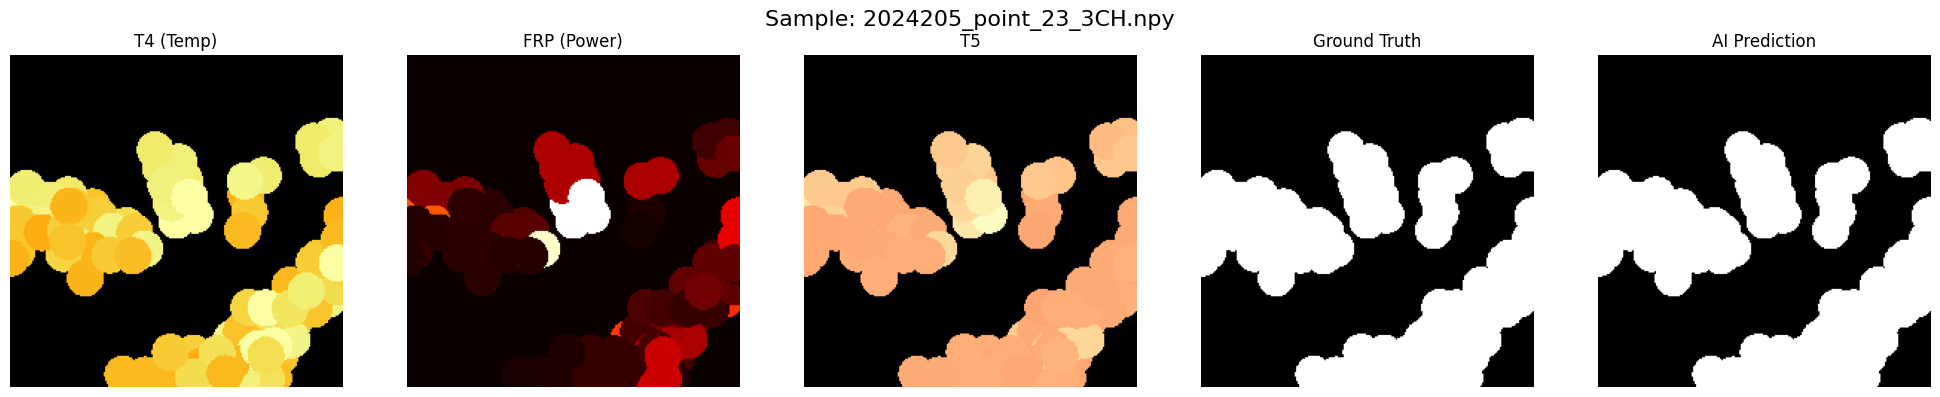

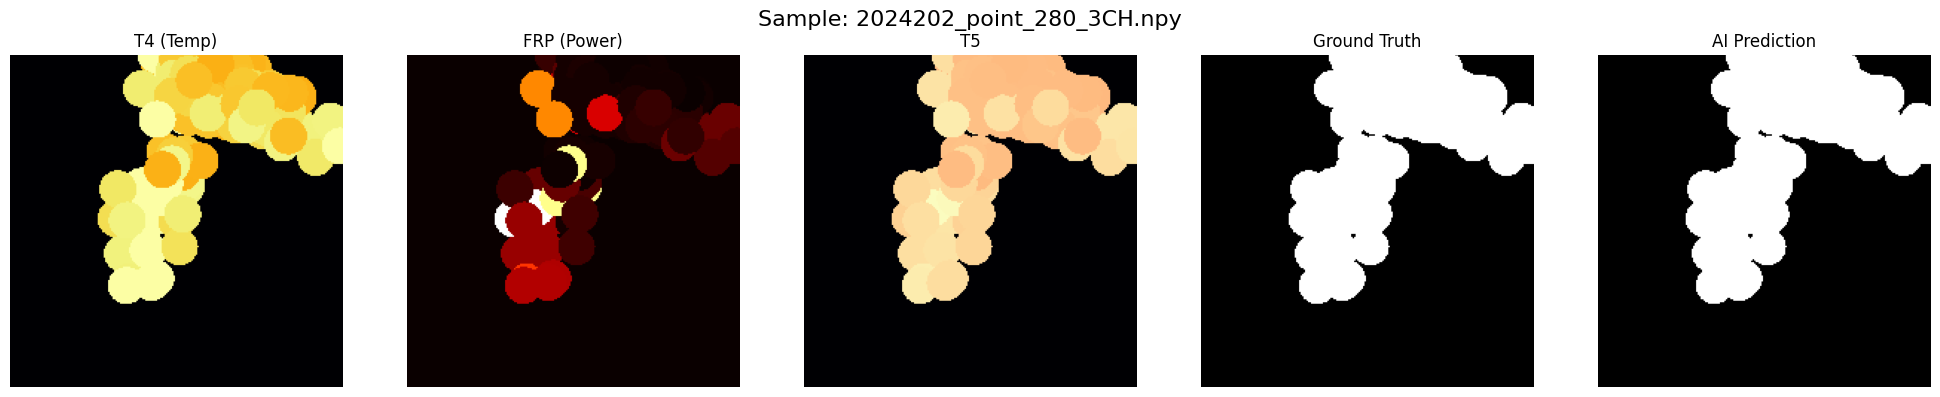

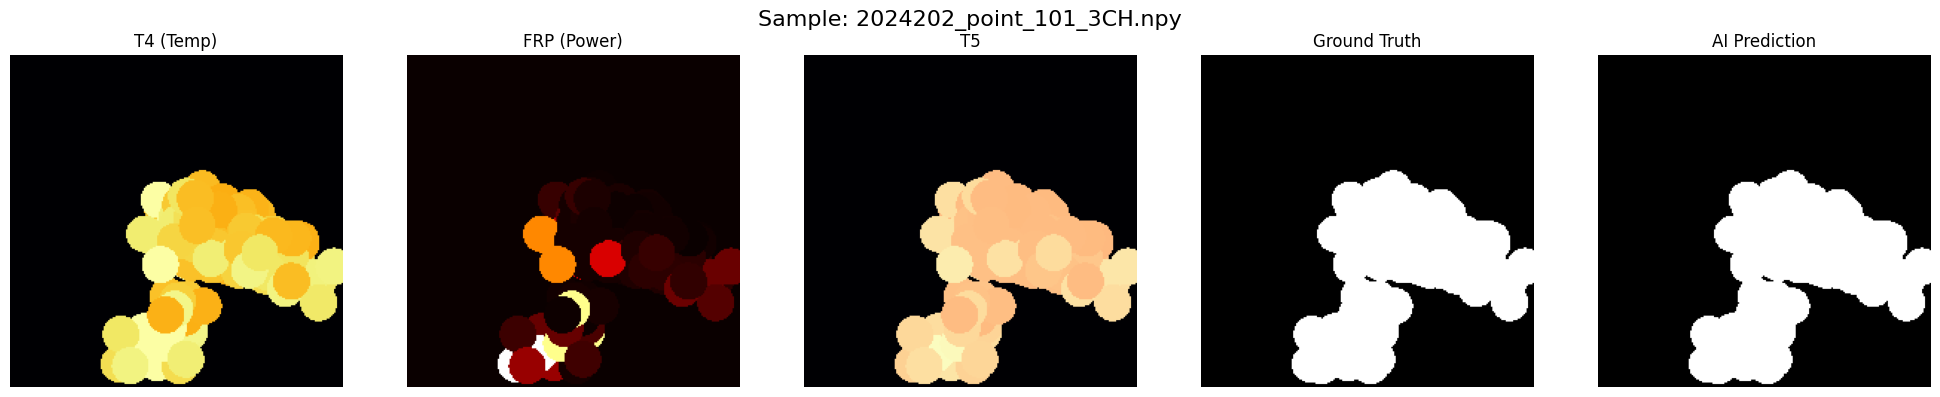

In [55]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
from glob import glob
import random
import torch.nn as nn

# Configuration
MODEL_PATH = r"D:\606Data\Processed\Models\unet_3ch_final.pth"
DATA_DIR = r"D:\606Data\Processed\Chips\Positive"
IMG_DIR = os.path.join(DATA_DIR, "Images")
LBL_DIR = os.path.join(DATA_DIR, "Labels")
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model Structure
class SimpleUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(SimpleUNet, self).__init__()
        def double_conv(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
                nn.ReLU(inplace=True)
            )
        self.d1 = double_conv(in_channels, 64)
        self.pool = nn.MaxPool2d(2)
        self.d2 = double_conv(64, 128)
        self.d3 = double_conv(128, 256)
        self.d4 = double_conv(256, 512)
        self.bottleneck = double_conv(512, 1024)
        self.up1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.u1 = double_conv(1024, 512)
        self.up2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.u2 = double_conv(512, 256)
        self.up3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.u3 = double_conv(256, 128)
        self.up4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.u4 = double_conv(128, 64)
        self.final = nn.Conv2d(64, out_channels, kernel_size=1)
        
    def forward(self, x):
        p1 = self.d1(x)
        x = self.pool(p1)
        p2 = self.d2(x)
        x = self.pool(p2)
        p3 = self.d3(x)
        x = self.pool(p3)
        p4 = self.d4(x)
        x = self.pool(p4)
        x = self.bottleneck(x)
        x = self.up1(x)
        x = torch.cat((p4, x), dim=1)
        x = self.u1(x)
        x = self.up2(x)
        x = torch.cat((p3, x), dim=1)
        x = self.u2(x)
        x = self.up3(x)
        x = torch.cat((p2, x), dim=1)
        x = self.u3(x)
        x = self.up4(x)
        x = torch.cat((p1, x), dim=1)
        x = self.u4(x)
        return self.final(x)

def visualize_predictions(num_samples=5):
    print("Loading Model...")
    try:
        model = SimpleUNet(in_channels=3, out_channels=1).to(DEVICE)
        model.load_state_dict(torch.load(MODEL_PATH))
        model.eval()
    except Exception as e:
        print(f"Error loading model: {e}")
        return

    all_files = glob(os.path.join(IMG_DIR, "*.npy"))
    if not all_files:
        print("No files found.")
        return
        
    samples = random.sample(all_files, num_samples)
    
    for i, img_path in enumerate(samples):
        fname = os.path.basename(img_path)
        lbl_path = os.path.join(LBL_DIR, fname)
        
        # Load
        img = np.load(img_path).astype(np.float32) # (H, W, 3)
        mask = np.load(lbl_path).astype(np.float32) # (H, W)
        
        # Tensor Prep
        img_tensor = np.transpose(img, (2, 0, 1))
        img_tensor = torch.from_numpy(img_tensor).unsqueeze(0).to(DEVICE)
        
        # Inference
        with torch.no_grad():
            pred_logits = model(img_tensor)
            pred_mask = torch.sigmoid(pred_logits).cpu().numpy().squeeze()
            pred_binary = (pred_mask > 0.5).astype(np.float32)
            
        # Plot
        fig, ax = plt.subplots(1, 5, figsize=(20, 4))
        
        # Show Inputs
        ax[0].imshow(img[:,:,0], cmap='inferno')
        ax[0].set_title(f"T4 (Temp)")
        ax[0].axis('off')
        
        ax[1].imshow(img[:,:,1], cmap='hot')
        ax[1].set_title("FRP (Power)")
        ax[1].axis('off')
        
        ax[2].imshow(img[:,:,2], cmap='magma')
        ax[2].set_title("T5")
        ax[2].axis('off')
        
        # Show Truth vs Pred
        ax[3].imshow(mask, cmap='gray')
        ax[3].set_title("Ground Truth")
        ax[3].axis('off')
        
        ax[4].imshow(pred_binary, cmap='gray')
        ax[4].set_title("AI Prediction")
        ax[4].axis('off')
        
        plt.suptitle(f"Sample: {fname}", fontsize=16)
        plt.tight_layout()
        plt.show()

if __name__ == "__main__":
    visualize_predictions()


1. Generating U-Net 3D Thermal Plot


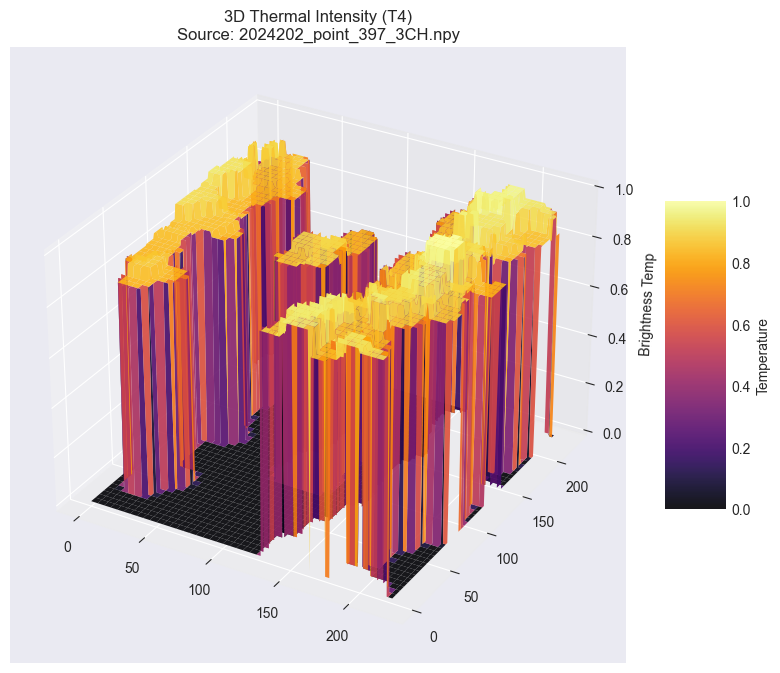


2. Generating LSTM Diagnostic Plots
Found Data: D:\606Data\Processed\smap_time_series.csv
   Using column: 'Moisture'


C:\Users\sanjay\AppData\Local\Temp\ipykernel_14224\3840067723.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(LSTM_MODEL_PATH))


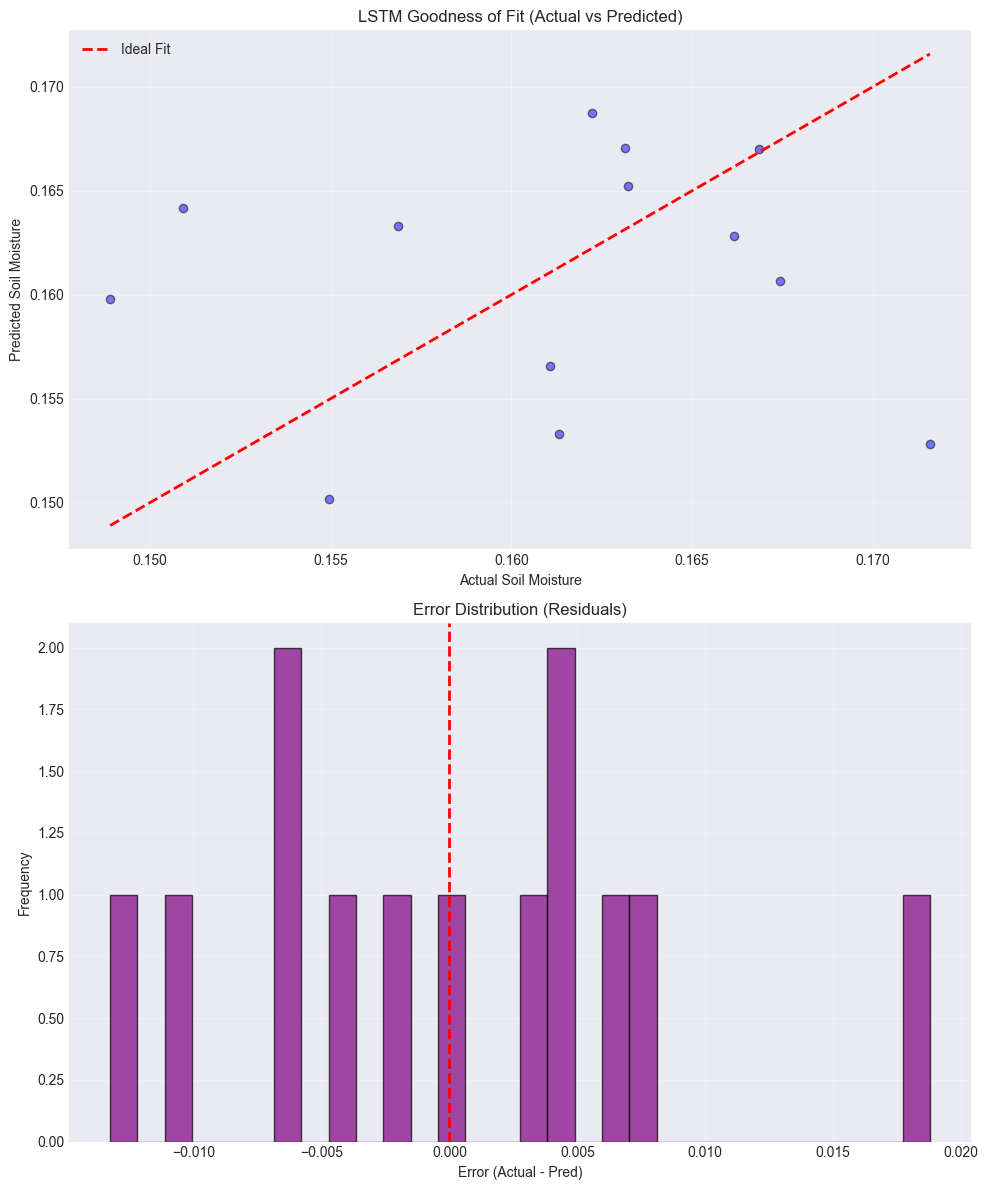

LSTM Diagnostics Generated.


In [26]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import pandas as pd
from glob import glob
import random
from sklearn.preprocessing import MinMaxScaler

# Configuration
LSTM_DATA_CSV = r"D:\606Data\Processed\smap_time_series.csv"

# Model Paths
UNET_MODEL_PATH = r"C:\Users\sanjay\Documents\GitHub\UMBC-DATA606-Capstone\Models\unet_3ch_final.pth"
LSTM_MODEL_PATH = r"C:\Users\sanjay\Documents\GitHub\UMBC-DATA606-Capstone\Models\drought_lstm.pth"

# Data Directories
UNET_DATA_DIR = r"D:\606Data\Processed\Chips\Positive"

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model Definations
# U-Net 
class SimpleUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(SimpleUNet, self).__init__()
        def double_conv(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
                nn.ReLU(inplace=True)
            )
        self.d1 = double_conv(in_channels, 64)
        self.pool = nn.MaxPool2d(2)
        self.d2 = double_conv(64, 128)
        self.d3 = double_conv(128, 256)
        self.d4 = double_conv(256, 512)
        self.bottleneck = double_conv(512, 1024)
        self.up1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.u1 = double_conv(1024, 512)
        self.up2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.u2 = double_conv(512, 256)
        self.up3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.u3 = double_conv(256, 128)
        self.up4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.u4 = double_conv(128, 64)
        self.final = nn.Conv2d(64, out_channels, kernel_size=1)
    def forward(self, x):
        p1 = self.d1(x); x = self.pool(p1)
        p2 = self.d2(x); x = self.pool(p2)
        p3 = self.d3(x); x = self.pool(p3)
        p4 = self.d4(x); x = self.pool(p4)
        x = self.bottleneck(x)
        x = self.up1(x); x = torch.cat((p4, x), dim=1); x = self.u1(x)
        x = self.up2(x); x = torch.cat((p3, x), dim=1); x = self.u2(x)
        x = self.up3(x); x = torch.cat((p2, x), dim=1); x = self.u3(x)
        x = self.up4(x); x = torch.cat((p1, x), dim=1); x = self.u4(x)
        return self.final(x)

# LSTM 
class DroughtLSTM(nn.Module):
    def __init__(self, hidden_size=32):
        super(DroughtLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

# Plotting 
def visualize_unet_3d(data_dir):
    print("\n1. Generating U-Net 3D Thermal Plot")
    img_dir = os.path.join(data_dir, "Images")
    all_files = glob(os.path.join(img_dir, "*.npy"))
    
    if not all_files:
        print("❌ No images found.")
        return

    path = random.choice(all_files)
    img = np.load(path)
    t4 = img[:,:,0] 
    
    x = np.arange(0, t4.shape[1], 1)
    y = np.arange(0, t4.shape[0], 1)
    X, Y = np.meshgrid(x, y)
    
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X, Y, t4, cmap='inferno', edgecolor='none', alpha=0.9)
    
    ax.set_title(f"3D Thermal Intensity (T4)\nSource: {os.path.basename(path)}")
    ax.set_zlabel("Brightness Temp")
    fig.colorbar(surf, shrink=0.5, aspect=5, label="Temperature")
    
    plt.show()

def visualize_lstm_diagnostics():
    print("\n2. Generating LSTM Diagnostic Plots")
    
    # Load Model
    model = DroughtLSTM(hidden_size=32).to(DEVICE)
    try:
        model.load_state_dict(torch.load(LSTM_MODEL_PATH))
        model.eval()
    except Exception as e:
        print(f"Error loading LSTM model: {e}")
        return

    if os.path.exists(LSTM_DATA_CSV):
        print(f"Found Data: {LSTM_DATA_CSV}")
        df = pd.read_csv(LSTM_DATA_CSV)
        
        possible_cols = ['Moisture', 'soil_moisture', 'value', 'sm']
        col = next((c for c in possible_cols if c in df.columns), None)
        
        if col:
            print(f"   Using column: '{col}'")
            data = df[col].values[-500:] 
        else:
            print(f"Could not find a moisture column in {df.columns}")
            return
    else:
        print(f"CSV FILE NOT FOUND at: {LSTM_DATA_CSV}")
        return

    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(data.reshape(-1, 1))
    
    SEQ_LEN = 3
    X_seq, y_seq = [], []
    for i in range(len(data_scaled) - SEQ_LEN):
        X_seq.append(data_scaled[i:i+SEQ_LEN])
        y_seq.append(data_scaled[i+SEQ_LEN])
        
    X_torch = torch.tensor(X_seq, dtype=torch.float32).to(DEVICE)
    
    # Predict
    with torch.no_grad():
        preds_scaled = model(X_torch).cpu().numpy()
        
    # Inverse Transform to get real values
    actuals = scaler.inverse_transform(np.array(y_seq).reshape(-1, 1)).flatten()
    preds = scaler.inverse_transform(preds_scaled).flatten()

    fig, ax = plt.subplots(2, 1, figsize=(10, 12))
    
    ax[0].scatter(actuals, preds, alpha=0.5, color='blue', edgecolors='k')
    
    min_val, max_val = min(actuals.min(), preds.min()), max(actuals.max(), preds.max())
    ax[0].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Ideal Fit')
    
    ax[0].set_title("LSTM Goodness of Fit (Actual vs Predicted)")
    ax[0].set_xlabel("Actual Soil Moisture")
    ax[0].set_ylabel("Predicted Soil Moisture")
    ax[0].legend()
    ax[0].grid(True, alpha=0.3)
    
    residuals = actuals - preds
    ax[1].hist(residuals, bins=30, color='purple', alpha=0.7, edgecolor='black')
    ax[1].axvline(0, color='red', linestyle='dashed', linewidth=2)
    
    ax[1].set_title("Error Distribution (Residuals)")
    ax[1].set_xlabel("Error (Actual - Pred)")
    ax[1].set_ylabel("Frequency")
    ax[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    print("LSTM Diagnostics Generated.")

# 4. Main Execution
if __name__ == "__main__":
    try:
        visualize_unet_3d(UNET_DATA_DIR)
    except Exception as e:
        print(f"Skipping U-Net 3D: {e}")

    try:
        visualize_lstm_diagnostics()
    except Exception as e:
        print(f"Skipping LSTM Diagnostics: {e}")

--- Searching for UNSEEN dates ---
Found 18 dates the model has never seen.
Selected Test Date: 2024206
--- Generating Inference Chips for 2024206 ---
--- Running AI Inference ---


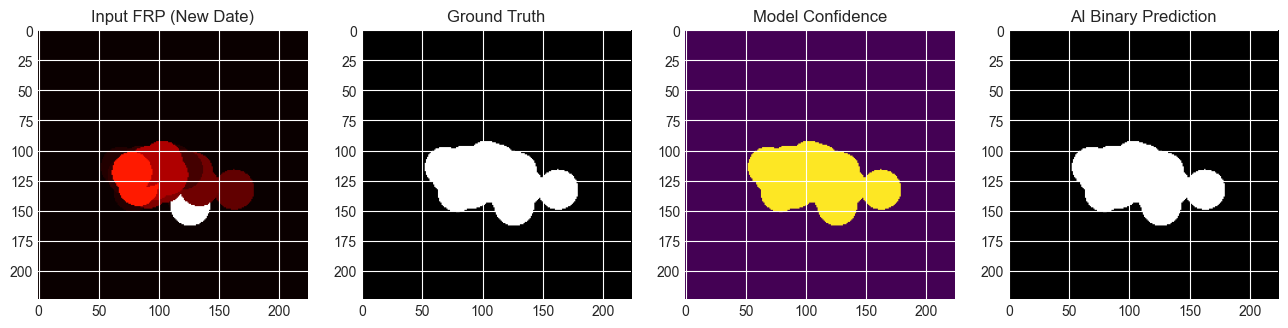

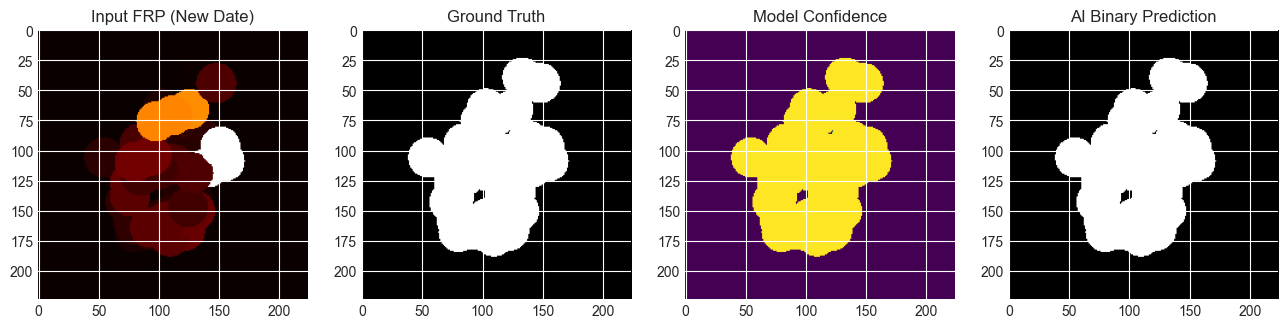

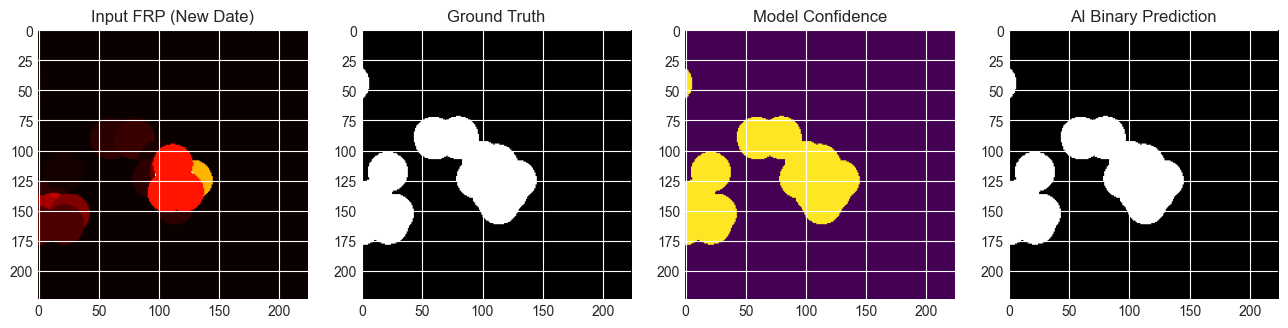

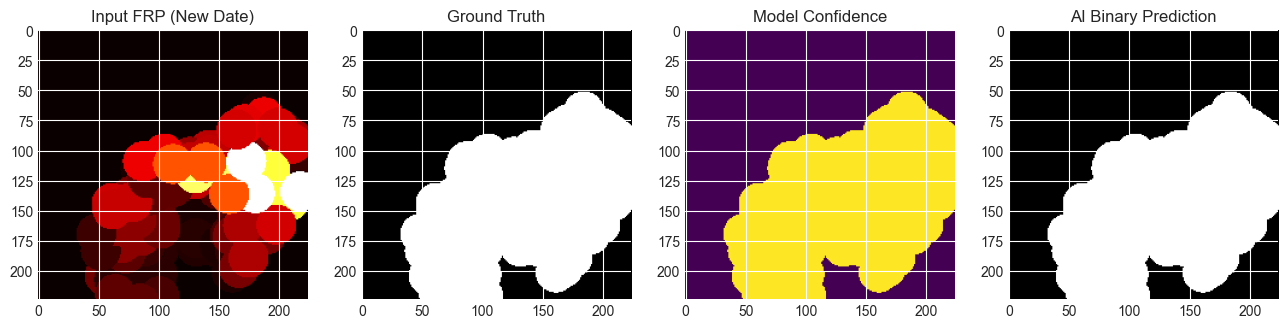

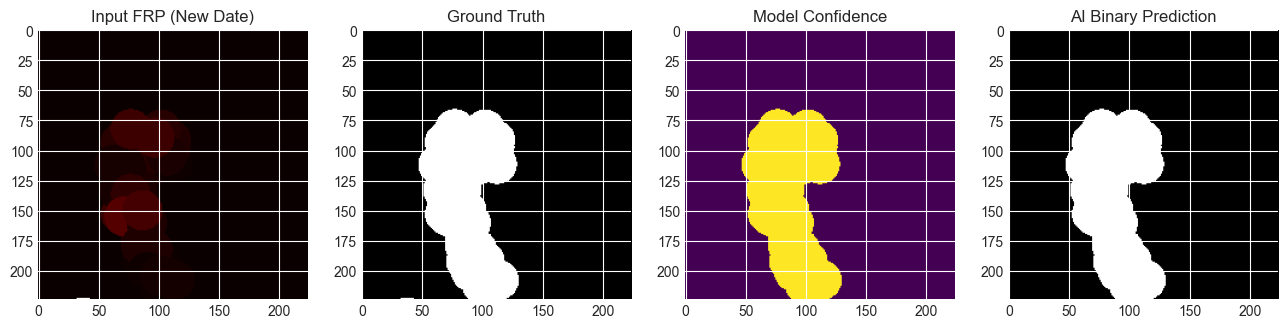

In [25]:
import os
import pandas as pd
import numpy as np
import rasterio
from rasterio.features import rasterize
import geopandas as gpd
from glob import glob
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from rasterio.transform import from_bounds
import random

# Configuration
# 1. Paths
OUTPUT_BASE = r"D:\606Data\Processed\Inference"
MODEL_PATH = r"C:\Users\sanjay\Documents\GitHub\UMBC-DATA606-Capstone\Models\unet_3ch_final.pth"
VIIRS_DIRS = [
    r"D:\606Data\VIIRSJPSS1_Active_Fires_6Min_L2Swath_375m_V002\Data",
    r"D:\606Data\VIIRSNPP_ActiveFires_6Min_L2Swath_375m_V002\Data"
]

# 2. Settings
TRAINED_DATES = ['2024204', '2024207', '2024205', '2024203', '2024202']
TARGET_CRS = "EPSG:6842" 
TARGET_RESOLUTION = 30.0
CHIP_SIZE = 224
BUFFER_METERS = 500.0 
FEATURE_COLUMNS = ['T4', 'FRP', 'T5'] 
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model Defination
class SimpleUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(SimpleUNet, self).__init__()
        def double_conv(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
                nn.ReLU(inplace=True)
            )
        self.d1 = double_conv(in_channels, 64)
        self.pool = nn.MaxPool2d(2)
        self.d2 = double_conv(64, 128)
        self.d3 = double_conv(128, 256)
        self.d4 = double_conv(256, 512)
        self.bottleneck = double_conv(512, 1024)
        self.up1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.u1 = double_conv(1024, 512)
        self.up2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.u2 = double_conv(512, 256)
        self.up3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.u3 = double_conv(256, 128)
        self.up4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.u4 = double_conv(128, 64)
        self.final = nn.Conv2d(64, out_channels, kernel_size=1)
        
    def forward(self, x):
        p1 = self.d1(x)
        x = self.pool(p1)
        p2 = self.d2(x)
        x = self.pool(p2)
        p3 = self.d3(x)
        x = self.pool(p3)
        p4 = self.d4(x)
        x = self.pool(p4)
        x = self.bottleneck(x)
        x = self.up1(x)
        x = torch.cat((p4, x), dim=1)
        x = self.u1(x)
        x = self.up2(x)
        x = torch.cat((p3, x), dim=1)
        x = self.u2(x)
        x = self.up3(x)
        x = torch.cat((p2, x), dim=1)
        x = self.u3(x)
        x = self.up4(x)
        x = torch.cat((p1, x), dim=1)
        x = self.u4(x)
        return self.final(x)

def find_unseen_date():
    print("--- Searching for UNSEEN dates ---")
    all_files = []
    for d in VIIRS_DIRS:
        all_files.extend(glob(os.path.join(d, "*.csv")))
        all_files.extend(glob(os.path.join(d, "*.txt")))
    
    found_dates = set()
    for f in all_files:
        if "A2024" in f:
            try:
                part = f.split("A2024")[1][:3]
                julian = f"2024{part}"
                found_dates.add(julian)
            except: continue
            
    unseen = list(found_dates - set(TRAINED_DATES))
    
    if not unseen:
        print("No unseen dates found! We will re-test on a training date (Sanity Check).")
        return TRAINED_DATES[0]
    
    print(f"Found {len(unseen)} dates the model has never seen.")
    target = sorted(unseen)[0] 
    print(f"Selected Test Date: {target}")
    return target

def generate_inference_chips(date):
    print(f"--- Generating Inference Chips for {date} ---")
    os.makedirs(OUTPUT_BASE, exist_ok=True)
    
    # 1. Load Data
    fire_dfs = []
    for v_dir in VIIRS_DIRS:
        fire_files = glob(os.path.join(v_dir, f"**/*A{date}*.csv"), recursive=True)
        fire_files += glob(os.path.join(v_dir, f"**/*A{date}*.txt"), recursive=True)
        for path in fire_files:
            try:
                df = pd.read_csv(path)
                df['latitude'] = pd.to_numeric(df['latitude'], errors='coerce')
                df['longitude'] = pd.to_numeric(df['longitude'], errors='coerce')
                for col in FEATURE_COLUMNS: df[col] = pd.to_numeric(df[col], errors='coerce')
                df.dropna(subset=['latitude', 'longitude'] + FEATURE_COLUMNS, inplace=True)
                df = df[pd.to_numeric(df['confidence'], errors='coerce') >= 7]
                if not df.empty: fire_dfs.append(df)
            except: continue
            
    if not fire_dfs:
        print("No valid data found for this date.")
        return []

    full_df = pd.concat(fire_dfs, ignore_index=True)
    gdf = gpd.GeoDataFrame(full_df, geometry=gpd.points_from_xy(full_df.longitude, full_df.latitude), crs="EPSG:4326").to_crs(TARGET_CRS)
    
    # 2. Generate Chips 
    chips = []
    sample_gdf = gdf.sample(n=min(5, len(gdf))).reset_index(drop=True)
    
    for idx, row in sample_gdf.iterrows():
        pt = row.geometry
        transform = from_bounds(pt.x - 3360, pt.y - 3360, pt.x + 3360, pt.y + 3360, CHIP_SIZE, CHIP_SIZE)
        
        stacked = np.zeros((CHIP_SIZE, CHIP_SIZE, 3), dtype=np.float32)
        for i, col in enumerate(FEATURE_COLUMNS):
            neighbors = gdf.cx[pt.x-5000:pt.x+5000, pt.y-5000:pt.y+5000]
            shapes = ((geom.buffer(BUFFER_METERS), val) for geom, val in zip(neighbors.geometry, neighbors[col]))
            channel = rasterize(shapes, out_shape=(CHIP_SIZE, CHIP_SIZE), transform=transform, fill=0, dtype=np.float32)
            if channel.max() > 0: channel /= channel.max()
            stacked[:, :, i] = channel
            
        shapes_lbl = ((geom.buffer(BUFFER_METERS), 1) for geom in neighbors.geometry)
        mask = rasterize(shapes_lbl, out_shape=(CHIP_SIZE, CHIP_SIZE), transform=transform, fill=0, dtype=np.uint8)
        
        chips.append((stacked, mask))
        
    return chips

def run_inference(chips):
    print("--- Running AI Inference ---")
    model = SimpleUNet(in_channels=3, out_channels=1).to(DEVICE)
    try:
        model.load_state_dict(torch.load(MODEL_PATH, weights_only=True)) 
    except:
        model.load_state_dict(torch.load(MODEL_PATH))
        
    model.eval()
    
    for i, (img, true_mask) in enumerate(chips):
        input_tensor = torch.from_numpy(np.transpose(img, (2, 0, 1))).unsqueeze(0).to(DEVICE)
        
        with torch.no_grad():
            pred = torch.sigmoid(model(input_tensor)).cpu().numpy().squeeze()
            pred_binary = (pred > 0.5).astype(np.float32)
            
        fig, ax = plt.subplots(1, 4, figsize=(16, 4))
        ax[0].imshow(img[:,:,1], cmap='hot'); ax[0].set_title("Input FRP (New Date)")
        ax[1].imshow(true_mask, cmap='gray'); ax[1].set_title("Ground Truth")
        ax[2].imshow(pred, cmap='viridis'); ax[2].set_title("Model Confidence")
        ax[3].imshow(pred_binary, cmap='gray'); ax[3].set_title("AI Binary Prediction")
        plt.show()

if __name__ == "__main__":
    test_date = find_unseen_date()
    generated_chips = generate_inference_chips(test_date)
    if generated_chips:
        run_inference(generated_chips)

# Crop Health Monitoring

--- SMAP DATA VISUALIZER ---
Loading: SMAP_L3_SM_P_20240720_R19240_001.h5
Data Shape: (406, 964)
Min Moisture: 0.0200
Max Moisture: 0.7487 cm^3/cm^3


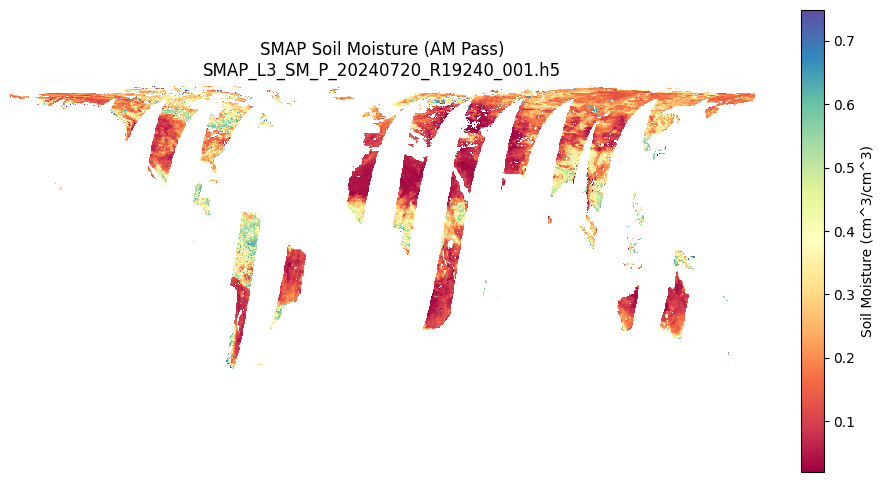

In [59]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

SMAP_DIR = r"D:\606Data\SMAP_L3_Radiometer_Global_Daily_36km_EAS_Grid_Soil_Moisture_V009\Data"

def visualize_smap():
    print("--- SMAP DATA VISUALIZER ---")
    
    files = glob(os.path.join(SMAP_DIR, "*.h5"))
    if not files:
        print("❌ No SMAP L3 files found. Checking Enhanced directory...")
        SMAP_DIR_ALT = r"D:\606Data\SMAP_Enhanced_L3_Radiometer_Global_and_PolarGrid_Daily_9km_EASE_Grid_SoilMoisture_V006\Data"
        files = glob(os.path.join(SMAP_DIR_ALT, "*.h5"))
        if not files:
            print("CRITICAL ERROR: No SMAP H5 files found in any folder.")
            return
            
    sample_path = files[0]
    print(f"Loading: {os.path.basename(sample_path)}")
    
    try:
        with h5py.File(sample_path, 'r') as f:
            group_key = 'Soil_Moisture_Retrieval_Data_AM'
            
            if group_key not in f:
                print(f"⚠️ Group '{group_key}' not found. Available keys: {list(f.keys())}")
                return

            moisture = f[group_key]['soil_moisture'][:]
            lat = f[group_key]['latitude'][:]
            lon = f[group_key]['longitude'][:]
            
            moisture = moisture.astype(np.float32)
            moisture[moisture < -9000] = np.nan
            
            print(f"Data Shape: {moisture.shape}")
            print(f"Min Moisture: {np.nanmin(moisture):.4f}")
            print(f"Max Moisture: {np.nanmax(moisture):.4f} cm^3/cm^3")

            plt.figure(figsize=(12, 6))
            plt.imshow(moisture, cmap='Spectral', interpolation='none')
            plt.colorbar(label='Soil Moisture (cm^3/cm^3)')
            plt.title(f"SMAP Soil Moisture (AM Pass)\n{os.path.basename(sample_path)}")
            plt.axis('off')
            plt.show()
            
    except Exception as e:
        print(f"❌ Error reading SMAP file: {e}")

if __name__ == "__main__":
    visualize_smap()

--- SMAP DROUGHT MONITOR ---
Targeting Location: 36.5, -120.0


Extracting Data: 100%|█████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 29.31it/s]



✅ Extraction Complete. Found 16 data points.
        Date  Moisture  Distance
0 2024-07-21  0.160993  0.138874
1 2024-07-22  0.160183  0.138874
2 2024-07-24  0.152453  0.138874
3 2024-07-27  0.171588  0.138874
4 2024-07-29  0.162232  0.138874


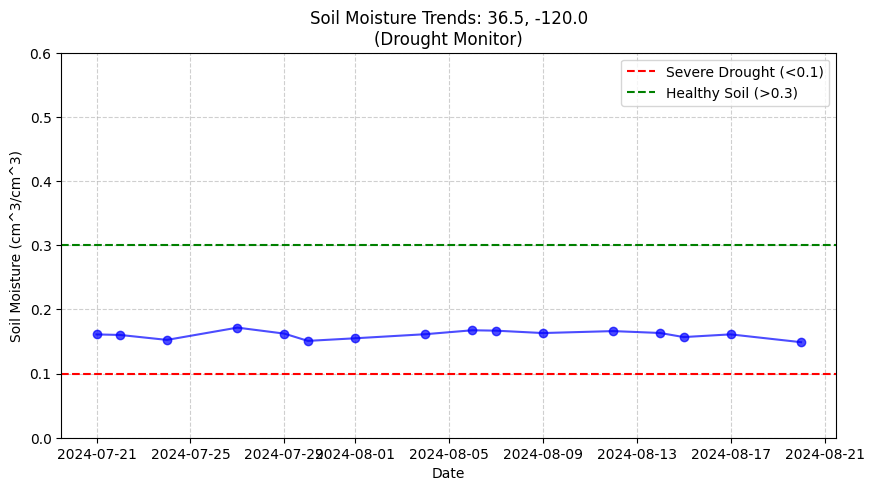

Data saved to: D:\606Data\Processed\smap_time_series.csv


In [60]:
import os
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm
import datetime

# Configuration
TARGET_LAT = 36.5 
TARGET_LON = -120.0

SMAP_DIR = r"D:\606Data\SMAP_L3_Radiometer_Global_Daily_36km_EAS_Grid_Soil_Moisture_V009\Data"

SEARCH_RADIUS = 0.5 

def extract_time_series():
    print(f"--- SMAP DROUGHT MONITOR ---")
    print(f"Targeting Location: {TARGET_LAT}, {TARGET_LON}")
    
    files = glob(os.path.join(SMAP_DIR, "*.h5"))
    if not files:
        print("CRITICAL ERROR: No SMAP files found.")
        return

    time_series_data = []
    
    for f_path in tqdm(files, desc="Extracting Data"):
        filename = os.path.basename(f_path)
        
        try:
            # 1. Parse Date from Filename
            date_str = filename.split('_')[4] 
            date_obj = datetime.datetime.strptime(date_str, "%Y%m%d")
            
            # 2. Open Data
            with h5py.File(f_path, 'r') as f:
                group_key = 'Soil_Moisture_Retrieval_Data_AM'
                if group_key not in f:
                    continue 

                lats = f[group_key]['latitude'][:]
                lons = f[group_key]['longitude'][:]
                moisture = f[group_key]['soil_moisture'][:]
                
                lats[lats < -90] = np.nan
                lons[lons < -180] = np.nan
                
                # 3. Find Nearest Pixel 
                dist = np.sqrt((lats - TARGET_LAT)**2 + (lons - TARGET_LON)**2)
                
                min_dist = np.nanmin(dist)
                
                if min_dist < SEARCH_RADIUS:
                    idx = np.unravel_index(np.nanargmin(dist), dist.shape)
                    
                    val = moisture[idx]
                    
                    if val > -1.0:
                        time_series_data.append({
                            'Date': date_obj,
                            'Moisture': val,
                            'Distance': min_dist
                        })
                        
        except Exception as e:
            print(f"Error processing {filename}: {e}")
            continue

    if not time_series_data:
        print("\n❌ No data found for this location in the available files.")
        print("Try changing the TARGET_LAT/LON to a region covered by your specific swaths.")
        return

    df = pd.DataFrame(time_series_data).sort_values(by='Date')
    
    print(f"\n✅ Extraction Complete. Found {len(df)} data points.")
    print(df.head())
    
    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(df['Date'], df['Moisture'], marker='o', linestyle='-', color='blue', alpha=0.7)
    plt.title(f"Soil Moisture Trends: {TARGET_LAT}, {TARGET_LON}\n(Drought Monitor)")
    plt.xlabel("Date")
    plt.ylabel("Soil Moisture (cm^3/cm^3)")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.ylim(0, 0.6) 
    
    plt.axhline(y=0.1, color='red', linestyle='--', label='Severe Drought (<0.1)')
    plt.axhline(y=0.3, color='green', linestyle='--', label='Healthy Soil (>0.3)')
    plt.legend()
    
    plt.show()
    
    csv_path = os.path.join(r"D:\606Data\Processed", "smap_time_series.csv")
    df.to_csv(csv_path, index=False)
    print(f"Data saved to: {csv_path}")

if __name__ == "__main__":
    extract_time_series()

✅ Final Plot Saved to GitHub: C:\Users\sanjay\Documents\GitHub\UMBC-DATA606-Capstone\Images\drought_monitor_result.png


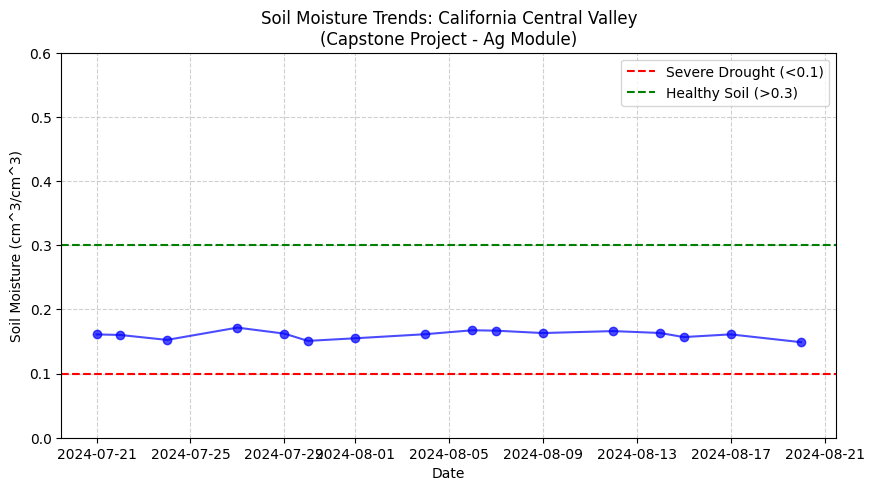

In [61]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Loading the data
csv_path = r"D:\606Data\Processed\smap_time_series.csv"
df = pd.read_csv(csv_path)

REPO_IMG_DIR = r"C:\Users\sanjay\Documents\GitHub\UMBC-DATA606-Capstone\Images"
os.makedirs(REPO_IMG_DIR, exist_ok=True)

plt.figure(figsize=(10, 5))
plt.plot(pd.to_datetime(df['Date']), df['Moisture'], marker='o', linestyle='-', color='blue', alpha=0.7)
plt.title("Soil Moisture Trends: California Central Valley\n(Capstone Project - Ag Module)")
plt.xlabel("Date")
plt.ylabel("Soil Moisture (cm^3/cm^3)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.ylim(0, 0.6)
plt.axhline(y=0.1, color='red', linestyle='--', label='Severe Drought (<0.1)')
plt.axhline(y=0.3, color='green', linestyle='--', label='Healthy Soil (>0.3)')
plt.legend()

save_path = os.path.join(REPO_IMG_DIR, "drought_monitor_result.png")
plt.savefig(save_path)
print(f"✅ Final Plot Saved to GitHub: {save_path}")

In [62]:
import os
import h5py
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
import datetime

# Configuration
MIN_LAT, MAX_LAT = 34.0, 40.0
MIN_LON, MAX_LON = -122.0, -118.0

# Output
CSV_PATH = r"D:\606Data\Processed\smap_bulk_training_data.csv"
SMAP_DIR = r"D:\606Data\SMAP_L3_Radiometer_Global_Daily_36km_EAS_Grid_Soil_Moisture_V009\Data"

def extract_bulk_data():
    print("--- 🚜 BULK SMAP EXTRACTION FOR LSTM TRAINING ---")
    files = glob(os.path.join(SMAP_DIR, "*.h5"))
    
    dataset = []
    
    for f_path in tqdm(files, desc="Mining Pixels"):
        try:
            filename = os.path.basename(f_path)
            date_str = filename.split('_')[4]
            date_obj = datetime.datetime.strptime(date_str, "%Y%m%d")
            
            with h5py.File(f_path, 'r') as f:
                if 'Soil_Moisture_Retrieval_Data_AM' not in f: continue
                
                # Load Arrays
                lats = f['Soil_Moisture_Retrieval_Data_AM']['latitude'][:]
                lons = f['Soil_Moisture_Retrieval_Data_AM']['longitude'][:]
                moisture = f['Soil_Moisture_Retrieval_Data_AM']['soil_moisture'][:]
                
                mask = (lats >= MIN_LAT) & (lats <= MAX_LAT) & \
                       (lons >= MIN_LON) & (lons <= MAX_LON) & \
                       (moisture > 0.0) 
                
                valid_moisture = moisture[mask]
                valid_lats = lats[mask]
                valid_lons = lons[mask]
                
                for m, lat, lon in zip(valid_moisture, valid_lats, valid_lons):
                    dataset.append({
                        'Date': date_obj,
                        'Lat': lat,
                        'Lon': lon,
                        'Moisture': m
                    })
                    
        except Exception:
            continue
            
    df = pd.DataFrame(dataset)
    print(f"\n✅ Extracted {len(df)} samples from the grid.")
    
    if len(df) > 0:
        df.to_csv(CSV_PATH, index=False)
        print(f"Training data saved to: {CSV_PATH}")
    else:
        print("❌ No data found in that lat/lon box. Try expanding the bounds.")

if __name__ == "__main__":
    extract_bulk_data()

--- 🚜 BULK SMAP EXTRACTION FOR LSTM TRAINING ---


Mining Pixels: 100%|███████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 48.80it/s]


✅ Extracted 2537 samples from the grid.
Training data saved to: D:\606Data\Processed\smap_bulk_training_data.csv


--- 1. MINING DATA (EXPANDED REGION) ---


Scanning Files: 100%|██████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 49.23it/s]


✅ Extracted 12068 samples.
--- 2. CREATING TIME-SERIES SEQUENCES ---


Building Sequences: 100%|████████████████████████████████████████████████████████| 6093/6093 [00:00<00:00, 6846.16it/s]


✅ Generated 3899 valid training sequences.
--- 3. TRAINING LSTM (30 Epochs) ---
Epoch 5: Train Loss 0.0045 | Val Loss 0.0044
Epoch 10: Train Loss 0.0042 | Val Loss 0.0041
Epoch 15: Train Loss 0.0039 | Val Loss 0.0037
Epoch 20: Train Loss 0.0034 | Val Loss 0.0032
Epoch 25: Train Loss 0.0029 | Val Loss 0.0026
Epoch 30: Train Loss 0.0025 | Val Loss 0.0024


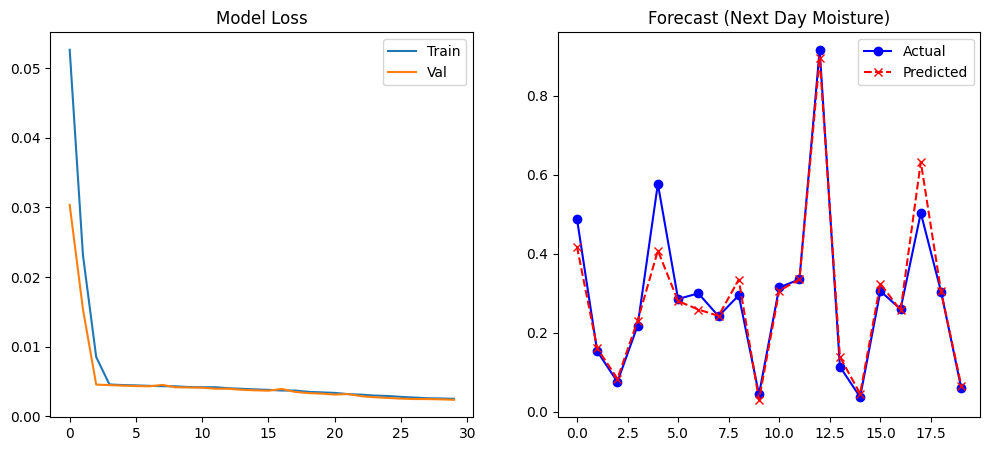

✅ LSTM Model Saved.


In [65]:
import os
import h5py
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
import datetime
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# 1. Extraction Settings 
MIN_LAT, MAX_LAT = 25.0, 50.0
MIN_LON, MAX_LON = -125.0, -65.0

SMAP_DIR = r"D:\606Data\SMAP_L3_Radiometer_Global_Daily_36km_EAS_Grid_Soil_Moisture_V009\Data"
CSV_PATH = r"D:\606Data\Processed\smap_us_training_data.csv"

# 2. Model Settings
SEQ_LENGTH = 3
HIDDEN_SIZE = 32
NUM_EPOCHS = 30
LEARNING_RATE = 0.001
BATCH_SIZE = 64
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def extract_bulk_data():
    print("--- 1. MINING DATA (EXPANDED REGION) ---")
    files = glob(os.path.join(SMAP_DIR, "*.h5"))
    dataset = []
    
    for f_path in tqdm(files, desc="Scanning Files"):
        try:
            filename = os.path.basename(f_path)
            date_str = filename.split('_')[4]
            date_obj = datetime.datetime.strptime(date_str, "%Y%m%d")
            
            with h5py.File(f_path, 'r') as f:
                if 'Soil_Moisture_Retrieval_Data_AM' not in f: continue
                
                lats = f['Soil_Moisture_Retrieval_Data_AM']['latitude'][:]
                lons = f['Soil_Moisture_Retrieval_Data_AM']['longitude'][:]
                moisture = f['Soil_Moisture_Retrieval_Data_AM']['soil_moisture'][:]
                
                mask = (lats >= MIN_LAT) & (lats <= MAX_LAT) & \
                       (lons >= MIN_LON) & (lons <= MAX_LON) & \
                       (moisture > 0.0)
                
                valid_moisture = moisture[mask]
                valid_lats = lats[mask]
                valid_lons = lons[mask]
                
                step = 10
                for m, lat, lon in zip(valid_moisture[::step], valid_lats[::step], valid_lons[::step]):
                    dataset.append({'Date': date_obj, 'Lat': lat, 'Lon': lon, 'Moisture': m})
                    
        except Exception: continue
            
    df = pd.DataFrame(dataset)
    print(f"✅ Extracted {len(df)} samples.")
    return df

def prepare_sequences(df):
    print("--- 2. CREATING TIME-SERIES SEQUENCES ---")
    
    df['Date'] = pd.to_datetime(df['Date'])
    df['LocID'] = list(zip(df.Lat.round(1), df.Lon.round(1))) # Round to grouping pixels
    
    scaler = MinMaxScaler(feature_range=(0, 1))
    df['Moisture_Scaled'] = scaler.fit_transform(df[['Moisture']])
    
    X, y = [], []
    
    grouped = df.groupby('LocID')
    
    for loc, group in tqdm(grouped, desc="Building Sequences"):
        if len(group) < SEQ_LENGTH + 1: continue
        
        group = group.sort_values('Date').set_index('Date')
        
        group_daily = group['Moisture_Scaled'].resample('D').mean().interpolate(method='linear', limit=2)
        
        vals = group_daily.dropna().values
        
        if len(vals) <= SEQ_LENGTH: continue
            
        for i in range(len(vals) - SEQ_LENGTH):
            seq_x = vals[i : i+SEQ_LENGTH]
            label_y = vals[i+SEQ_LENGTH]
            X.append(seq_x)
            y.append(label_y)

    X = np.array(X)
    y = np.array(y)
    print(f"✅ Generated {len(X)} valid training sequences.")
    return X, y, scaler

class DroughtLSTM(nn.Module):
    def __init__(self):
        super(DroughtLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=HIDDEN_SIZE, batch_first=True)
        self.fc = nn.Linear(HIDDEN_SIZE, 1)
        
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

def run_pipeline():
    # 1. Extract
    df = extract_bulk_data()
    if len(df) < 100:
        print("Not enough data to train.")
        return

    # 2. Prepare
    X, y, scaler = prepare_sequences(df)
    if len(X) == 0:
        print("Still 0 sequences. Try increasing interpolation limit.")
        return
        
    # Reshape
    X = X.reshape(-1, SEQ_LENGTH, 1)
    y = y.reshape(-1, 1)
    
    # Split
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Loaders
    train_loader = DataLoader(TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float()), batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(TensorDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float()), batch_size=BATCH_SIZE)
    
    # 3. Train
    print(f"--- 3. TRAINING LSTM ({NUM_EPOCHS} Epochs) ---")
    model = DroughtLSTM().to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.MSELoss()
    
    train_hist, val_hist = [], []
    
    for epoch in range(NUM_EPOCHS):
        model.train()
        loss_accum = 0
        for bx, by in train_loader:
            bx, by = bx.to(DEVICE), by.to(DEVICE)
            optimizer.zero_grad()
            loss = criterion(model(bx), by)
            loss.backward()
            optimizer.step()
            loss_accum += loss.item()
            
        val_loss = 0
        model.eval()
        with torch.no_grad():
            for bx, by in val_loader:
                bx, by = bx.to(DEVICE), by.to(DEVICE)
                val_loss += criterion(model(bx), by).item()
                
        avg_train = loss_accum / len(train_loader)
        avg_val = val_loss / len(val_loader)
        train_hist.append(avg_train)
        val_hist.append(avg_val)
        
        if (epoch+1) % 5 == 0:
            print(f"Epoch {epoch+1}: Train Loss {avg_train:.4f} | Val Loss {avg_val:.4f}")

    # 4. Visualize
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_hist, label='Train')
    plt.plot(val_hist, label='Val')
    plt.title("Model Loss")
    plt.legend()
    
    # Inference Test
    plt.subplot(1, 2, 2)
    model.eval()
    with torch.no_grad():
        bx, by = next(iter(val_loader))
        bx = bx.to(DEVICE)
        preds = model(bx).cpu().numpy()
        actuals = by.numpy()
        
    plt.plot(actuals[:20], 'b-o', label='Actual')
    plt.plot(preds[:20], 'r--x', label='Predicted')
    plt.title("Forecast (Next Day Moisture)")
    plt.legend()
    plt.show()
    
    torch.save(model.state_dict(), r"C:\Users\sanjay\Documents\GitHub\UMBC-DATA606-Capstone\Models\drought_lstm.pth")
    print("✅ LSTM Model Saved.")

if __name__ == "__main__":
    run_pipeline()